# Segmenting and Clustering Neighborhoods in Toronto

## Peer-graded Assignment Week 3

## Creating the Data Frame

In [1]:
!pip install geocoder
!pip install folium

    100% |████████████████████████████████| 102kB 6.8MB/s ta 0:00:01
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from geocoder)
Requirement not upgraded as not directly required: click in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from geocoder)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from geocoder)
Requirement not upgraded as not directly required: future in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from geocoder)
Requirement not upgraded as not directly required: decorator in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from ratelim->geocoder)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->geocoder)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Pyt

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import geocoder # convert a postcode into coordinates
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

First obtain the HTML page with the list of Toronto neighborhoods using the request library.

In [4]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

Parse the page into BeautifulSoup format so we can use BS to work on it. Create the BS object.

In [5]:
soup = BeautifulSoup(page, 'lxml')

Find the table in the BS object.

In [6]:
table = soup.find('table', {'class':"wikitable sortable"})

Find all rows in the table.

In [7]:
table_rows = table.find_all('tr')

Create a list containing all table rows excluding the 'Not assigned' postcodes.

In [8]:
lst = []
for tr in table_rows:
    if 'Not assigned' not in tr.text:
        lst.append(tr.text.strip())
        
lst[0:10]

['Postcode\nBorough\nNeighbourhood',
 'M3A\nNorth York\nParkwoods',
 'M4A\nNorth York\nVictoria Village',
 'M5A\nDowntown Toronto\nHarbourfront',
 'M5A\nDowntown Toronto\nRegent Park',
 'M6A\nNorth York\nLawrence Heights',
 'M6A\nNorth York\nLawrence Manor',
 'M9A\nEtobicoke\nIslington Avenue',
 'M1B\nScarborough\nRouge',
 'M1B\nScarborough\nMalvern']

Split each line and place it as a list into a new list.

In [9]:
splitted_list = []
for element in lst:
    splitted_line = element.split('\n')
    splitted_list.append(splitted_line)

splitted_list[0:10]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M9A', 'Etobicoke', 'Islington Avenue'],
 ['M1B', 'Scarborough', 'Rouge'],
 ['M1B', 'Scarborough', 'Malvern']]

Based on the list with splitted lines, create a dictionary for the data frame.

In [10]:
dic = {}
borough_lst = []
neighborhood_lst = []
postcode_lst = []

for header in splitted_list[0]:
    dic[header] = None

for i in range(1, len(splitted_list)):
    data_line = splitted_list[i]
    postcode_lst.append(data_line[0])
    borough_lst.append(data_line[1])
    neighborhood_lst.append(data_line[2])

dic['PostalCode'] = postcode_lst
dic['Borough'] = borough_lst
dic['Neighborhood'] = neighborhood_lst

In [11]:
df = pd.DataFrame(dic, columns=['PostalCode', 'Borough', 'Neighborhood'])
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [12]:
grouped  = df.groupby(df['PostalCode'], sort=False).agg({'Borough':'min', 'Neighborhood': lambda g: ", ".join(g)}).reset_index()
grouped.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M9A,Etobicoke,Islington Avenue


In [13]:
grouped.shape[0]

102

## Obtaining the coordinates

Turn the column "PostalCode" to a list. It will be used for obtaining the coordinates.

In [14]:
poscode_unique_lst = grouped['PostalCode'].tolist()

Obtain the coordinates of the postal codes using the Python Geocoder library.

In [15]:
neighborhood_lat = []
neighborhood_lon = []
for i in range(len(poscode_unique_lst)):
    lat_lng_coords = None
    while lat_lng_coords is None:
        g = geocoder.google('{}, Toronto, Ontario'.format(poscode_unique_lst[i]))
        lat_lng_coords = g.latlng
    neighborhood_lat.append(lat_lng_coords[0])
    neighborhood_lon.append(lat_lng_coords[1])

Add the Latitude and Longitude lists into the grouped data frame.

In [16]:
grouped['Latitude'] = neighborhood_lat
grouped['Longitude'] = neighborhood_lon
grouped.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242


## Visualize the neighborhoods

Obtain the coordinates of Toronto using geopy.geocoders.

In [17]:
address = 'Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Create the folium map of Toronto neigborhoods.

In [19]:
# create map of Toronto using latitude and longitude values
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(grouped['Latitude'], grouped['Longitude'], grouped['Borough'], grouped['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(toronto_map)  
    
toronto_map

Create a new df containing only the boroughs with the word "Toronto" in them.

In [20]:
toronto_central = grouped[grouped['Borough'].str.contains('Toronto')].sort_values('Neighborhood').reset_index(drop=True)
toronto_central.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
1,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
2,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191
3,M7Y,East Toronto,Business reply mail Processing Centre969 Eastern,43.662744,-79.321558
4,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420


Let's get the geographical coordinates of Downtown Toronto.

In [21]:
address = 'Downtown Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Downtown are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto Downtown are 43.654027, -79.3802003.


Visualize the neigborhoods in the df toronto_central.

In [22]:
# create map of Toronto using latitude and longitude values
toronto_central_map = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(toronto_central['Latitude'], toronto_central['Longitude'], toronto_central['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(toronto_central_map)  
    
toronto_central_map

## Explore example neighbourhood using Foursquare API

Use the Foursquare API to explore the neighborhoods and segment them.


Define Foursquare Credentials and Version

In [23]:
CLIENT_ID = 'SVEWXBLGDUZYFRLDCI0CQXHTGHFUASSAK5G1CAFFNAPH5COZ' # your Foursquare ID
CLIENT_SECRET = '5G3KVAWC332CYBUDIRT45F3MGZJOWPSMAJU0ODVWA4TKQIM3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SVEWXBLGDUZYFRLDCI0CQXHTGHFUASSAK5G1CAFFNAPH5COZ
CLIENT_SECRET:5G3KVAWC332CYBUDIRT45F3MGZJOWPSMAJU0ODVWA4TKQIM3


Get the neighborhood's name and find its coordinates.

In [24]:
toronto_central.loc[0, 'Neighborhood']

'Adelaide, King, Richmond'

In [25]:
neighborhood_latitude = toronto_central.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_central.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_central.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Adelaide, King, Richmond are 43.65057119999999, -79.3845675.


Now, let's get the top 100 venues that are in this neighborhood within a radius of 500 meters.

create the GET request URL

In [26]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=SVEWXBLGDUZYFRLDCI0CQXHTGHFUASSAK5G1CAFFNAPH5COZ&client_secret=5G3KVAWC332CYBUDIRT45F3MGZJOWPSMAJU0ODVWA4TKQIM3&v=20180605&ll=43.65057119999999,-79.3845675&radius=500&limit=100'

Send the GET request and examine the results.

In [27]:
results = requests.get(url).json()

All the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the json and structure it into a pandas dataframe by flattening the json file (method json_normalize()).

In [29]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4ad4c05ef964a520a6f620e3-0,"[{'primary': True, 'id': '4bf58dd8d48988d16494...",4ad4c05ef964a520a6f620e3,100 Queen St W,CA,Toronto,Canada,at Bay St,...,"[{'label': 'display', 'lat': 43.65227047322295...",43.652270,-79.383516,NaN,M5H 2N1,ON,Nathan Phillips Square,0,[],NaN
1,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4ad4c062f964a520e5f720e3-1,"[{'primary': True, 'id': '5032792091d4c4b30a58...",4ad4c062f964a520e5f720e3,145 Queen St. W,CA,Toronto,Canada,at University Ave.,...,"[{'label': 'display', 'lat': 43.65060862138792...",43.650609,-79.386280,NaN,M5H 4G1,ON,Four Seasons Centre for the Performing Arts,0,[],NaN
2,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4ad69511f964a520e40721e3-2,"[{'primary': True, 'id': '4bf58dd8d48988d1cc94...",4ad69511f964a520e40721e3,165 York St,CA,Toronto,Canada,btwn Richmond St. & Adelaide St.,...,"[{'label': 'display', 'lat': 43.64993725298525...",43.649937,-79.384196,NaN,M5H 3R8,ON,The Keg Steakhouse & Bar,0,[],NaN
3,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4e048b98315168be7fd7ee4d-3,"[{'primary': True, 'id': '4bf58dd8d48988d10e94...",4e048b98315168be7fd7ee4d,133 Richmond St. W,CA,Toronto,Canada,at York St.,...,"[{'label': 'display', 'lat': 43.65032912559998...",43.650329,-79.384533,NaN,M5H 2L3,ON,Estiatorio Volos,0,[],75877391
4,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4e31b74252b131dcebb08743-4,"[{'primary': True, 'id': '4bf58dd8d48988d1fa93...",4e31b74252b131dcebb08743,188 University Ave.,CA,Toronto,Canada,at Adelaide St. W,...,"[{'label': 'display', 'lat': 43.64912919417502...",43.649129,-79.386557,NaN,M5H 0A3,ON,Shangri-La Toronto,0,[],NaN


In [30]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Nathan Phillips Square,Plaza,43.652270,-79.383516
1,Four Seasons Centre for the Performing Arts,Concert Hall,43.650609,-79.386280
2,The Keg Steakhouse & Bar,Steakhouse,43.649937,-79.384196
3,Estiatorio Volos,Greek Restaurant,43.650329,-79.384533
4,Shangri-La Toronto,Hotel,43.649129,-79.386557


## Explore neighbourhoods in Central Toronto

Create a function to repeat the same process to all the neighborhoods in central Toronto

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Write the code to run the above function on each neighborhood and create a new dataframe called toronto_downtown_venues.

In [32]:
toronto_downtown_venues = getNearbyVenues(names=toronto_central['Neighborhood'],
                                   latitudes=toronto_central['Latitude'],
                                   longitudes=toronto_central['Longitude']
                                  )

Adelaide, King, Richmond
Berczy Park
Brockton, Exhibition Place, Parkdale Village
Business reply mail Processing Centre969 Eastern
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Cabbagetown, St. James Town
Central Bay Street
Chinatown, Grange Park, Kensington Market
Christie
Church and Wellesley
Commerce Court, Victoria Hotel
Davisville
Davisville North
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Design Exchange, Toronto Dominion Centre
Dovercourt Village, Dufferin
First Canadian Place, Underground city
Forest Hill North, Forest Hill West
Harbord, University of Toronto
Harbourfront East, Toronto Islands, Union Station
Harbourfront, Regent Park
High Park, The Junction South
Lawrence Park
Little Portugal, Trinity
Moore Park, Summerhill East
North Toronto West
Parkdale, Roncesvalles
Rosedale
Roselawn
Runnymede, Swansea
Ryerson, Garden District
St. James Town
Stn A PO Boxes 25 The Esplanade
Studio District
Th

In [33]:
print(toronto_downtown_venues.shape)
toronto_downtown_venues.head()

(1698, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Adelaide, King, Richmond",43.650571,-79.384568,Nathan Phillips Square,43.652270,-79.383516,Plaza
1,"Adelaide, King, Richmond",43.650571,-79.384568,Four Seasons Centre for the Performing Arts,43.650609,-79.386280,Concert Hall
2,"Adelaide, King, Richmond",43.650571,-79.384568,The Keg Steakhouse & Bar,43.649937,-79.384196,Steakhouse
3,"Adelaide, King, Richmond",43.650571,-79.384568,Estiatorio Volos,43.650329,-79.384533,Greek Restaurant
4,"Adelaide, King, Richmond",43.650571,-79.384568,Shangri-La Toronto,43.649129,-79.386557,Hotel


Check how many venues were returned for each neighborhood:

In [34]:
toronto_downtown_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business reply mail Processing Centre969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",50,50,50,50,50,50
Central Bay Street,88,88,88,88,88,88
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


Find out how many unique categories can be curated from all the returned venues

In [35]:
'There are {} uniques categories.'.format(len(toronto_downtown_venues['Venue Category'].unique()))

'There are 232 uniques categories.'

## Analyze Each Neighborhood

One hot encoding creates new (binary) columns, indicating the presence of each possible value from the original data.

In [36]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_downtown_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [37]:
toronto_onehot.shape

(1698, 232)

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

mean = sum of the occurences of the category for each neighborhood / number of rows (venues) in manhattan_onehot for each neighborhood

Tells us the ratio of the category related to all venues (i.e. how many percent the category has out of all venues in the neighborhood).

** This will be the df used for K-means clustering. **

In [38]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,"Adelaide, King, Richmond",0.000000,0.01,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.0
1,Berczy Park,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
3,Business reply mail Processing Centre969 Eastern,0.058824,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.00,0.0,0.0,0.071429,0.071429,0.071429,0.142857,0.142857,...,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0


In [39]:
toronto_grouped.shape

(38, 232)

In [40]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index() # T to transpose rows and columns
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.05
2           Steakhouse  0.04
3                  Bar  0.04
4  American Restaurant  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2      Farmers Market  0.04
3              Bakery  0.04
4  Seafood Restaurant  0.04


----Brockton, Exhibition Place, Parkdale Village----
               venue  freq
0        Coffee Shop  0.14
1               Café  0.09
2     Breakfast Spot  0.09
3  Convenience Store  0.05
4             Office  0.05


----Business reply mail Processing Centre969 Eastern----
                venue  freq
0  Light Rail Station  0.12
1         Yoga Studio  0.06
2       Auto Workshop  0.06
3       Garden Center  0.06
4              Garden  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lou

Write a function to sort the venues in descending order.

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,American Restaurant,Thai Restaurant,Hotel,Burger Joint,Bakery,Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Cheese Shop,Beer Bar,Bakery,Steakhouse,Restaurant,Café,Farmers Market
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Breakfast Spot,Café,Pet Store,Performing Arts Venue,Burrito Place,Caribbean Restaurant,Climbing Gym,Convenience Store,Stadium
3,Business reply mail Processing Centre969 Eastern,Light Rail Station,Yoga Studio,Burrito Place,Auto Workshop,Restaurant,Spa,Fast Food Restaurant,Farmers Market,Brewery,Garden
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Terminal,Airport Service,Airport Lounge,Airport Gate,Boutique,Plane,Harbor / Marina,Airport Food Court,Airport,Sculpture Garden


## Cluster Neighborhoods

In [43]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1,
       2, 0, 2, 2, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [44]:
toronto_merged = toronto_central

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,2,Coffee Shop,Café,Bar,Steakhouse,American Restaurant,Thai Restaurant,Hotel,Burger Joint,Bakery,Restaurant
1,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Cocktail Bar,Seafood Restaurant,Cheese Shop,Beer Bar,Bakery,Steakhouse,Restaurant,Café,Farmers Market
2,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,2,Coffee Shop,Breakfast Spot,Café,Pet Store,Performing Arts Venue,Burrito Place,Caribbean Restaurant,Climbing Gym,Convenience Store,Stadium
3,M7Y,East Toronto,Business reply mail Processing Centre969 Eastern,43.662744,-79.321558,2,Light Rail Station,Yoga Studio,Burrito Place,Auto Workshop,Restaurant,Spa,Fast Food Restaurant,Farmers Market,Brewery,Garden
4,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,2,Airport Terminal,Airport Service,Airport Lounge,Airport Gate,Boutique,Plane,Harbor / Marina,Airport Food Court,Airport,Sculpture Garden


Visualize the resulting clusters

In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Print each neighborhood along with the top 5 most common venues.

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, 11))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
24,"Moore Park, Summerhill East",0,Gym,Intersection,Restaurant,Comic Shop,Comfort Food Restaurant


In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, 11))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,Davisville North,1,Park,Clothing Store,Breakfast Spot,Food & Drink Shop,Hotel
22,Lawrence Park,1,Bus Line,Dim Sum Restaurant,Park,Swim School,Event Space
27,Rosedale,1,Park,Playground,Trail,Wings Joint,Dim Sum Restaurant


In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, 11))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",2,Coffee Shop,Café,Bar,Steakhouse,American Restaurant
1,Berczy Park,2,Coffee Shop,Cocktail Bar,Seafood Restaurant,Cheese Shop,Beer Bar
2,"Brockton, Exhibition Place, Parkdale Village",2,Coffee Shop,Breakfast Spot,Café,Pet Store,Performing Arts Venue
3,Business reply mail Processing Centre969 Eastern,2,Light Rail Station,Yoga Studio,Burrito Place,Auto Workshop,Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",2,Airport Terminal,Airport Service,Airport Lounge,Airport Gate,Boutique
5,"Cabbagetown, St. James Town",2,Coffee Shop,Restaurant,Indian Restaurant,Café,Park
6,Central Bay Street,2,Coffee Shop,Italian Restaurant,Café,Chinese Restaurant,Burger Joint
7,"Chinatown, Grange Park, Kensington Market",2,Café,Vegetarian / Vegan Restaurant,Bakery,Chinese Restaurant,Bar
8,Christie,2,Café,Grocery Store,Park,Restaurant,Diner
9,Church and Wellesley,2,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant


In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, 11))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,"Forest Hill North, Forest Hill West",3,Jewelry Store,Trail,Mexican Restaurant,Sushi Restaurant,Wings Joint


In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, 11))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
28,Roselawn,4,Pool,Garden,Ice Cream Shop,Wings Joint,Dim Sum Restaurant


## Observations

The clusters are formed by the average frequency of the venue category, i.e. how often the type of venue appears in relation to other types.
This way of clustering can tell us a lot about the neighborhoods' character. For example, if there is a broad spectrum of venues, or if it is rather a quieter residential area.
To have a better insight in the cluster's distinction, I aggregated the neighborhoods within a cluster and created an average of their venue categories. Then I sorted venue categories and plotted the most frequent ones in a bar chart.

Let's add the clusters labels to the df toronto_grouped which was used for the clustering.

In [51]:
toronto_grouped['Cluster Labels'] = kmeans.labels_
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Cluster Labels
0,"Adelaide, King, Richmond",0.000000,0.01,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.0,2
1,Berczy Park,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,2
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,2
3,Business reply mail Processing Centre969 Eastern,0.058824,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,2
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.00,0.0,0.0,0.071429,0.071429,0.071429,0.142857,0.142857,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,2


Group the df toronto_grouped per clusters and the mean of the average frequency of the venue categories.

In [52]:
toronto_for_plot = toronto_grouped.groupby("Cluster Labels").mean()
toronto_for_plot

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.006894,0.000313,0.000363,0.000363,0.002232,0.002232,0.002232,0.004464,0.004464,0.004464,...,0.005157,0.001493,0.000744,0.001586,0.006502,0.001231,0.005135,0.000313,0.003031,0.000363
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
cluster_to_plot = toronto_for_plot.loc[2]
cluster_to_plot = cluster_to_plot[cluster_to_plot >= 0.02].sort_values()
cluster_to_plot

Grocery Store         0.020380
Bakery                0.022018
Restaurant            0.022448
Bar                   0.023065
Park                  0.023786
Pub                   0.024660
Italian Restaurant    0.025197
Café                  0.055566
Coffee Shop           0.088074
Name: 2, dtype: float64

In [54]:
def cluster_plotting(cluster_to_plot):
    cluster_to_plot = cluster_to_plot[cluster_to_plot >= 0.02].sort_values() # sort the categories in the cluster and filter out the ones that contribute by at least 2%
    cluster_to_plot.plot(kind='barh', figsize=(7,7))
    plt.title('Main Venues in Cluster {} of Toronto Neighborhoods'.format(cluster_to_plot.name))
    plt.xlabel('Average Frequency of Venue Category within Cluster')
    plt.ylabel('Venue Categories')

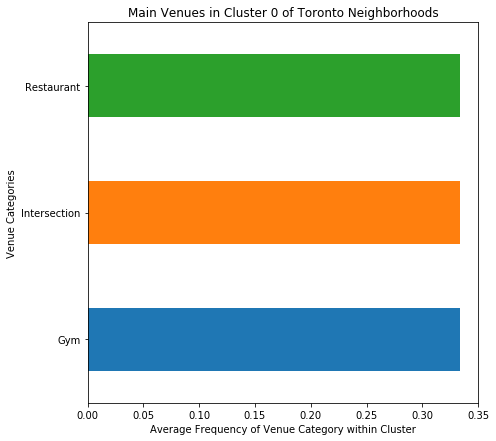

In [55]:
cluster_plotting(toronto_for_plot.loc[0])

Cluster 0 consists of only 1 neighbhorhood and 3 venues: restaurant, intersection and a gym. Will be an area of choice for sports but it does not offer much choice.

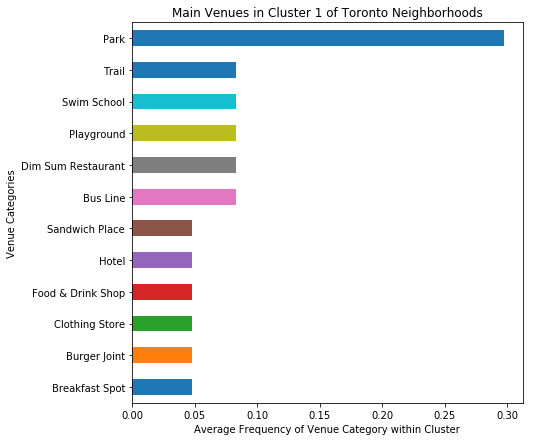

In [56]:
cluster_plotting(toronto_for_plot.loc[1])

Cluster 1 has only 3 neighborhoods but a variety of venues where parks are most frequent, followed by sports venues, eating out places and hotels. Ideal locations for outdoor enthusiasts.

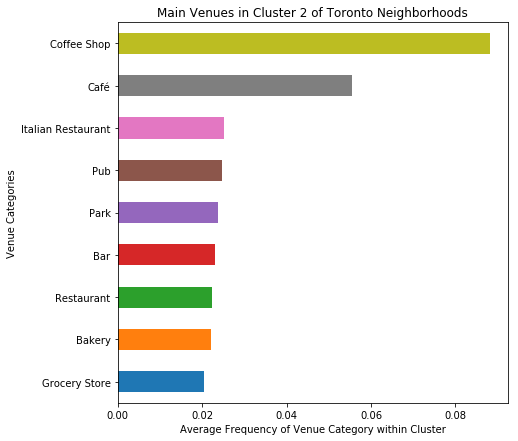

In [61]:
cluster_plotting(toronto_for_plot.loc[2])

Cluster 2 is the largest cluster, containing most of the neighborhoods and is rich in venues. There is a broad spectrum of venues, the most significant ones being coffee places and various eating out places. 

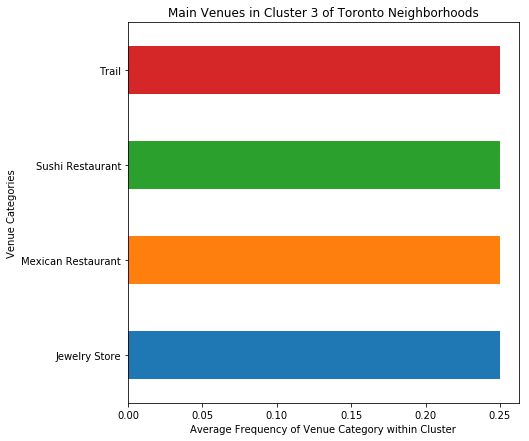

In [60]:
cluster_plotting(toronto_for_plot.loc[3])

Cluster 3 is the largest cluster, only 1 neighborhood. There is a trail and 2 restaurants. Ideal place for a trip.

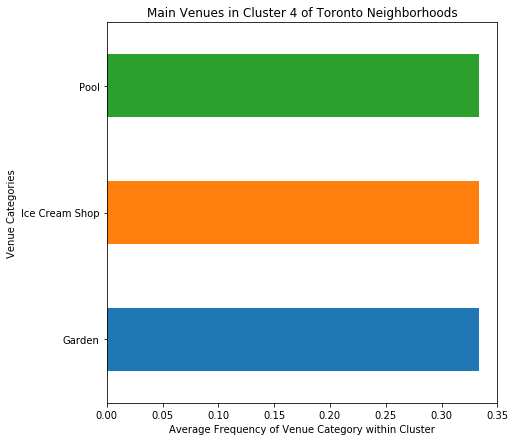

In [62]:
cluster_plotting(toronto_for_plot.loc[4])

Cluster 4 has only 3 venues, that is a pool, ice cream shop and a garden. Would be an area of choice for leisure activites and families.